In [1]:
# Import necessary libraries for data manipulation and analysis
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
from datetime import datetime, timedelta # Date operations

#Import necessary libraries for transformations
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import skew, kurtosis

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt # Matplotlib for basic plotting
import seaborn as sns # Seaborn for enhanced visualization
import plotly.express as px # Plotly for interactive plots

# Import libraries for time series analysis and modeling
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test for stationarity check
from statsmodels.tsa.stattools import kpss # Kwiatkowski-Phillips-Schmidt-Shin Test for stationarity check
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX model for time series forecasting
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition for trend, seasonal, and residual components
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima #SARIMAX using pmdarima

# Import necessary libraries for computing acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from statsmodels.tsa.stattools import acf, pacf  # For computing autocorrelation and partial autocorrelation

import joblib



SARIMAX for Visayas
DATA PREPROCESSING

In [4]:
labels_csv = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Visayas\train_labels_transformed.csv'
data_csv = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Visayas\train_data_transformed.csv'
test_data_csv=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Visayas/test_data.csv'
test_labels_csv=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Visayas/test_labels.csv'
transformed_data=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Visayas/data_transformed.csv'
complete_data = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Visayas/VIS_Daily_Complete.csv'

transformed_train_data = pd.read_csv(data_csv)
transformed_train_labels = pd.read_csv(labels_csv)
transformed_data = pd.read_csv(transformed_data)

test_data = pd.read_csv(test_data_csv)
test_labels = pd.read_csv(test_labels_csv)

complete_data_df = pd.read_csv(complete_data)
gwap = complete_data_df[['GWAP']]
lwap = complete_data_df[['LWAP']]



In [5]:
train_size = int(len(transformed_train_labels))  
test_size = int(len(test_data))

date_range = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
date_df = pd.DataFrame(date_range, columns=['Date'])

train_date = date_df[:train_size]
test_date = date_df[train_size:]

#Resetting the Index
train_date = train_date.reset_index(drop=True)
test_date = test_date.reset_index(drop=True)


In [6]:
#Preparing the dataframes
transformed_train_labels.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)
labels_columns = ['GWAP', 'LWAP']
labels_train = pd.DataFrame(transformed_train_labels, columns = labels_columns)
labels_test = pd.DataFrame(test_labels, columns = labels_columns)

transformed_train_data.rename(columns={'0':'FLOW_VIS', '1':'TMIN_Catbalogan', '2':'TMAX_Roxas City','3':'TMIN_Roxas City','4':'TMAX_Catarman','5':'TMIN_Catarman','6':'TMAX_Maasin','7':'TMIN_Maasin','8':'TMAX_Dumaguete', '9':'TMIN_Dumaguete', '10':'GWAP','11':'LWAP','12':'Hourly Demand','13':'TMAX_Catbalogan','14':'RESERVE_GWAP_Fr','15':'RESERVE_GWAP_Ru','16':'RESERVE_GWAP_Rd','17':'RESERVE_GWAP_Dr','18':'RAINFALL_Catbalogan','19':'RAINFALL_Roxas City','20':'RAINFALL_Catarman','21':'RAINFALL_Maasin','22':'RAINFALL_Dumaguete'}, inplace=True)
data_columns = ['FLOW_VIS', 'TMIN_Catbalogan', 'TMAX_Roxas City', 'TMIN_Roxas City', 'TMAX_Catarman', 'TMIN_Catarman', 'TMAX_Maasin', 'TMIN_Maasin', 'TMAX_Dumaguete', 'TMIN_Dumaguete','GWAP', 'LWAP', 'Hourly Demand', 'TMAX_Catbalogan','RESERVE_GWAP_Fr', 'RESERVE_GWAP_Ru', 'RESERVE_GWAP_Rd', 'RESERVE_GWAP_Dr', 'RAINFALL_Catbalogan', 'RAINFALL_Roxas City', 'RAINFALL_Catarman', 'RAINFALL_Maasin', 'RAINFALL_Dumaguete']
data_train = pd.DataFrame(transformed_train_data, columns = data_columns)
data_test = pd.DataFrame(test_data, columns = data_columns)

transformed_data.rename(columns={'0':'FLOW_VIS', '1':'TMIN_Catbalogan', '2':'TMAX_Roxas City','3':'TMIN_Roxas City','4':'TMAX_Catarman','5':'TMIN_Catarman','6':'TMAX_Maasin','7':'TMIN_Maasin','8':'TMAX_Dumaguete', '9':'TMIN_Dumaguete', '10':'GWAP','11':'LWAP','12':'Hourly Demand','13':'TMAX_Catbalogan','14':'RESERVE_GWAP_Fr','15':'RESERVE_GWAP_Ru','16':'RESERVE_GWAP_Rd','17':'RESERVE_GWAP_Dr','18':'RAINFALL_Catbalogan','19':'RAINFALL_Roxas City','20':'RAINFALL_Catarman','21':'RAINFALL_Maasin','22':'RAINFALL_Dumaguete'}, inplace=True)

In [7]:
#lagging the transformed data
transformed_data = transformed_data.shift(1)
transformed_data = transformed_data.fillna(0)

#Removing GWAP and LWAP
transformed_exog = transformed_data.drop(columns=['GWAP','LWAP'])



In [8]:
display(transformed_exog)

,FLOW_VIS,TMIN_Catbalogan,TMAX_Roxas City,TMIN_Roxas City,TMAX_Catarman,TMIN_Catarman,TMAX_Maasin,TMIN_Maasin,TMAX_Dumaguete,TMIN_Dumaguete,...,TMAX_Catbalogan,RESERVE_GWAP_Fr,RESERVE_GWAP_Ru,RESERVE_GWAP_Rd,RESERVE_GWAP_Dr,RAINFALL_Catbalogan,RAINFALL_Roxas City,RAINFALL_Catarman,RAINFALL_Maasin,RAINFALL_Dumaguete
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.340575,0.315217,0.186813,0.343750,0.163462,0.430380,0.242991,0.144928,0.177778,0.283019,...,0.053964,0.000000,0.000000,0.000000,0.000000,0.645009,0.355331,0.480482,0.909746,0.621255
2,0.340575,0.478261,0.175824,0.406250,0.221154,0.405063,0.000000,0.115942,0.033333,0.301887,...,0.115798,0.000000,0.000000,0.000000,0.000000,0.000000,0.530463,0.536810,0.946830,0.596027
3,0.340838,0.260870,0.241758,0.421875,0.326923,0.518987,0.168224,0.144928,0.188889,0.509434,...,0.232212,0.000000,0.000000,0.000000,0.000000,0.267562,0.437681,0.303641,0.881793,0.577080
4,0.341168,0.260870,0.450549,0.390625,0.230769,0.329114,0.383178,0.289855,0.422222,0.452830,...,0.099852,0.000000,0.000000,0.000000,0.000000,0.485851,0.530463,0.480482,0.308271,0.575755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.227998,0.586957,0.527473,0.734375,0.500000,0.493671,0.663551,0.579710,0.366667,0.528302,...,0.499511,0.286475,0.692074,0.999624,0.752703,0.569524,0.000000,0.638050,0.551440,0.591145
726,0.133112,0.586957,0.571429,0.703125,0.500000,0.468354,0.616822,0.362319,0.488889,0.490566,...,0.355802,0.282651,0.546595,0.999512,0.817765,0.298766,0.718014,0.678029,0.675988,0.576120
727,0.126162,0.586957,0.582418,0.703125,0.605769,0.518987,0.710280,0.507246,0.466667,0.433962,...,0.627124,0.000008,0.699256,0.999600,0.785420,0.468541,0.355331,0.444729,0.308271,0.575755
728,0.120391,0.630435,0.560440,0.734375,0.605769,0.493671,0.654206,0.507246,0.366667,0.660377,...,0.232212,0.248149,0.755170,0.999611,0.791577,0.576102,0.703114,0.568670,0.644848,0.577280


Multicollinearity Test

In [9]:
#Iteratively checking multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'exog_data' contains your exogenous variables
X = transformed_exog.copy()
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)



                feature        VIF
0              FLOW_VIS   9.091209
1       TMIN_Catbalogan  55.953834
2       TMAX_Roxas City  39.597518
3       TMIN_Roxas City  21.613591
4         TMAX_Catarman  46.164169
5         TMIN_Catarman  29.844423
6           TMAX_Maasin  41.676041
7           TMIN_Maasin  30.664720
8        TMAX_Dumaguete  35.128619
9        TMIN_Dumaguete  11.597900
10        Hourly Demand  24.855028
11      TMAX_Catbalogan  20.521745
12      RESERVE_GWAP_Fr   6.336994
13      RESERVE_GWAP_Ru   5.342260
14      RESERVE_GWAP_Rd   2.760546
15      RESERVE_GWAP_Dr   7.892215
16  RAINFALL_Catbalogan   7.833308
17  RAINFALL_Roxas City   7.198321
18    RAINFALL_Catarman  10.880303
19      RAINFALL_Maasin   8.069343
20   RAINFALL_Dumaguete  65.356915


In [13]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

# Check and remove high VIF variables iteratively
high_vif_threshold = 10  # Set your threshold here
while True:
    vif_data = calculate_vif(X)
    max_vif = vif_data['VIF'].max()
    
    if max_vif > high_vif_threshold:
        # Find the variable with the highest VIF
        feature_to_drop = vif_data.loc[vif_data['VIF'] == max_vif, 'feature'].values[0]
        print(f"Dropping {feature_to_drop} with VIF of {max_vif}")
        # Drop the variable and recalculate VIF
        X.drop(columns=[feature_to_drop], inplace=True)
    else:
        break

print("Final VIF values:\n", calculate_vif(X))
display(X)

Final VIF values:
                 feature       VIF
0              FLOW_VIS  6.472034
1        TMIN_Dumaguete  8.461147
2       TMAX_Catbalogan  6.521893
3       RESERVE_GWAP_Fr  5.556049
4       RESERVE_GWAP_Ru  4.707388
5       RESERVE_GWAP_Rd  2.509630
6       RESERVE_GWAP_Dr  6.050694
7   RAINFALL_Catbalogan  6.949692
8   RAINFALL_Roxas City  5.830259
9     RAINFALL_Catarman  8.737513
10      RAINFALL_Maasin  5.805614


,FLOW_VIS,TMIN_Dumaguete,TMAX_Catbalogan,RESERVE_GWAP_Fr,RESERVE_GWAP_Ru,RESERVE_GWAP_Rd,RESERVE_GWAP_Dr,RAINFALL_Catbalogan,RAINFALL_Roxas City,RAINFALL_Catarman,RAINFALL_Maasin
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.340575,0.283019,0.053964,0.000000,0.000000,0.000000,0.000000,0.645009,0.355331,0.480482,0.909746
2,0.340575,0.301887,0.115798,0.000000,0.000000,0.000000,0.000000,0.000000,0.530463,0.536810,0.946830
3,0.340838,0.509434,0.232212,0.000000,0.000000,0.000000,0.000000,0.267562,0.437681,0.303641,0.881793
4,0.341168,0.452830,0.099852,0.000000,0.000000,0.000000,0.000000,0.485851,0.530463,0.480482,0.308271
...,...,...,...,...,...,...,...,...,...,...,...
725,0.227998,0.528302,0.499511,0.286475,0.692074,0.999624,0.752703,0.569524,0.000000,0.638050,0.551440
726,0.133112,0.490566,0.355802,0.282651,0.546595,0.999512,0.817765,0.298766,0.718014,0.678029,0.675988
727,0.126162,0.433962,0.627124,0.000008,0.699256,0.999600,0.785420,0.468541,0.355331,0.444729,0.308271
728,0.120391,0.660377,0.232212,0.248149,0.755170,0.999611,0.791577,0.576102,0.703114,0.568670,0.644848


In [12]:
#Preparing the exog datasets
train_exog = X[:train_size]
test_exog = X[train_size:]


In [14]:
#Preparing transformed GWAP datasets
GWAP_train = labels_train['GWAP']
GWAP_train = pd.concat([train_date,GWAP_train], axis=1)
GWAP_train.set_index('Date', inplace=True)
GWAP_train.index = pd.to_datetime(GWAP_train.index)
GWAP_train.index.freq='D'
GWAP_train = GWAP_train.squeeze()


GWAP_test = labels_test['GWAP']
GWAP_test = pd.concat([test_date,GWAP_test], axis=1)
GWAP_test.set_index('Date', inplace=True)
GWAP_test.index = pd.to_datetime(GWAP_test.index)
GWAP_test.index.freq='D'
GWAP_test = GWAP_test.squeeze()

#Preparing original GWAP datasets
GWAP = pd.concat([date_df,gwap], axis=1)
GWAP.set_index('Date', inplace=True)
GWAP.index = pd.to_datetime(GWAP.index)
GWAP.index.freq='D'
GWAP = GWAP.squeeze()

GWAP_test_inversed = GWAP[train_size:]




#Preparing the transformed LWAP datasets
LWAP_train = labels_train['LWAP']
LWAP_train = pd.concat([train_date,LWAP_train], axis=1)
LWAP_train.set_index('Date', inplace=True)
LWAP_train.index = pd.to_datetime(LWAP_train.index)
LWAP_train.index.freq='D'
LWAP_train = LWAP_train.squeeze()

LWAP_test = labels_test['LWAP']
LWAP_test = pd.concat([test_date,LWAP_test], axis=1)
LWAP_test.set_index('Date', inplace=True)
LWAP_test.index = pd.to_datetime(LWAP_test.index)
LWAP_test.index.freq='D'
LWAP_test = LWAP_test.squeeze()

#Preparing the original LWAP datasets

LWAP = pd.concat([date_df,lwap], axis=1)
LWAP.set_index('Date', inplace=True)
LWAP.index = pd.to_datetime(LWAP.index)
LWAP.index.freq='D'
LWAP = LWAP.squeeze()

LWAP_test_inversed = LWAP[train_size:]



#Preparing the exogenous datasets
exog_train = pd.concat([train_date,train_exog], axis=1)
exog_train.set_index('Date', inplace=True)

test_exog = pd.DataFrame(test_exog)
test_exog = test_exog.reset_index()
exog_test = pd.concat([test_date,test_exog], axis=1)
exog_test.set_index('Date', inplace=True)
exog_test = exog_test.drop(columns=['index'])

In [15]:
#Applying the inverse transformations
#Loading inverse transformations for Visayas

minmax_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Visayas/minmax_scaler.pkl')
boxcox_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Visayas/boxcox_pipeline.pkl')
yeojohnson_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Visayas/yeojohnson_pipeline.pkl')
boxcoxy_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Visayas/boxcox_pipeliney.pkl')

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Jojie\A

In [16]:
#Plotting Train LWAP ang GWAP
# Create the line plot
gwap_plot = px.line(GWAP_train, x=GWAP_train.index, y='GWAP')
lwap_plot = px.line(LWAP_train, x=LWAP_train.index, y='LWAP')
# Set the title using the ticker value
gwap_plot.update_layout(title=f"Visayas GWAP")
lwap_plot.update_layout(title=f"Visayas LWAP")
# Display the plot
gwap_plot.show()
lwap_plot.show()

In [17]:
def perform_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Check initial stationarity
    for i in range(max_differences):
        adf_p_value = adf_test(data)
        kpss_p_value = kpss_test(data)

        # If ADF p-value is less than 0.05 and KPSS p-value is greater than 0.05, it's stationary
        if adf_p_value < 0.05 and kpss_p_value > 0.05:
            print(f"Data is stationary after differencing {i} times.")
            return data

        # If not stationary, apply differencing
        data = data.diff().dropna()

    print(f"Data could not be made stationary after {max_differences} differencing operations.")
    return data

#same test for dataframe
def perform_df_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS 
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Store in new DataFrame
    diff_exog = pd.DataFrame(index=data.index)

    # Check each column in the DataFrame
    for column in data.columns:
        series = data[column].copy()  # Copy the series to avoid modifying the original

        for i in range(max_differences):
            adf_p_value = adf_test(series)
            kpss_p_value = kpss_test(series)

            # If stationary, break the loop and store the series
            if adf_p_value < 0.05 and kpss_p_value > 0.05:
                print(f"Column '{column}' is stationary after differencing {i} times.")
                diff_exog[column] = series  # Store the stationary series
                break

            # If not stationary, apply differencing
            if i < max_differences - 1:  # Don't drop NA on the last iteration
                series = series.diff().dropna()

        else:  # This else corresponds to the for-loop
            print(f"Column '{column}' could not be made stationary after {max_differences} differencing operations.")
            diff_exog[column] = series  # Store the last differenced result

    return diff_exog


In [18]:
#Checking for stationarity in GWAP data
perform_differencing(GWAP_train)
perform_differencing(LWAP_train)



Data is stationary after differencing 0 times.
Data is stationary after differencing 0 times.


Date
2022-01-01    0.000501
2022-01-02    0.000000
2022-01-03    0.218610
2022-01-04    0.153859
2022-01-05    0.247301
                ...   
2023-08-03    0.431814
2023-08-04    0.570586
2023-08-05    0.468382
2023-08-06    0.465701
2023-08-07    0.483897
Freq: D, Name: LWAP, Length: 584, dtype: float64

In [19]:
diff_exog_train = perform_df_differencing(exog_train)
diff_exog_train = diff_exog_train.fillna(0)

C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\24

Column 'FLOW_VIS' is stationary after differencing 0 times.
Column 'TMIN_Dumaguete' is stationary after differencing 0 times.
Column 'TMAX_Catbalogan' is stationary after differencing 0 times.
Column 'RESERVE_GWAP_Fr' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Ru' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Rd' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Dr' is stationary after differencing 1 times.
Column 'RAINFALL_Catbalogan' is stationary after differencing 0 times.
Column 'RAINFALL_Roxas City' is stationary after differencing 0 times.
Column 'RAINFALL_Catarman' is stationary after differencing 0 times.
Column 'RAINFALL_Maasin' is stationary after differencing 0 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\24

In [20]:
diff_exog_test = perform_df_differencing(exog_test)
diff_exog_test = diff_exog_test.fillna(0)


Column 'FLOW_VIS' is stationary after differencing 1 times.
Column 'TMIN_Dumaguete' is stationary after differencing 2 times.
Column 'TMAX_Catbalogan' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Fr' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Ru' is stationary after differencing 0 times.
Column 'RESERVE_GWAP_Rd' is stationary after differencing 0 times.
Column 'RESERVE_GWAP_Dr' is stationary after differencing 0 times.
Column 'RAINFALL_Catbalogan' is stationary after differencing 0 times.
Column 'RAINFALL_Roxas City' is stationary after differencing 0 times.
Column 'RAINFALL_Catarman' is stationary after differencing 1 times.
Column 'RAINFALL_Maasin' is stationary after differencing 1 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17544\24

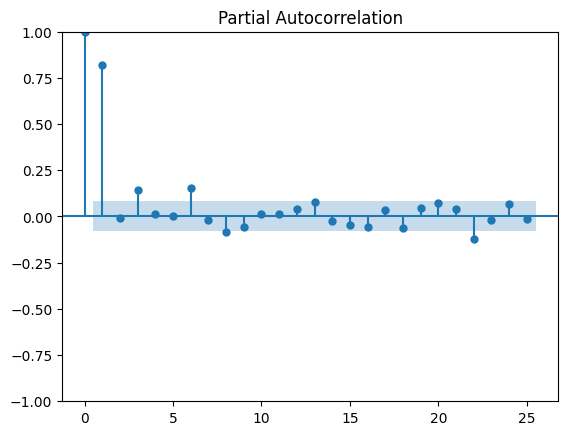

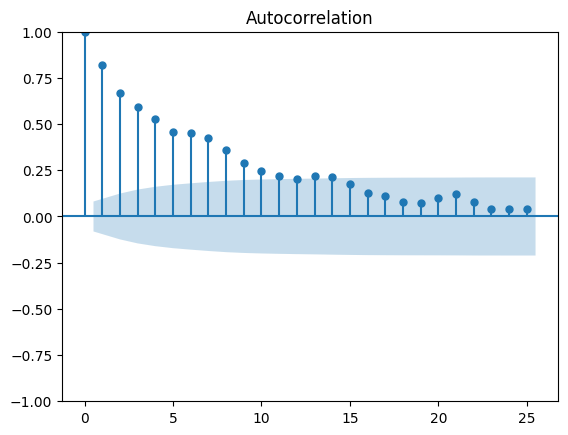

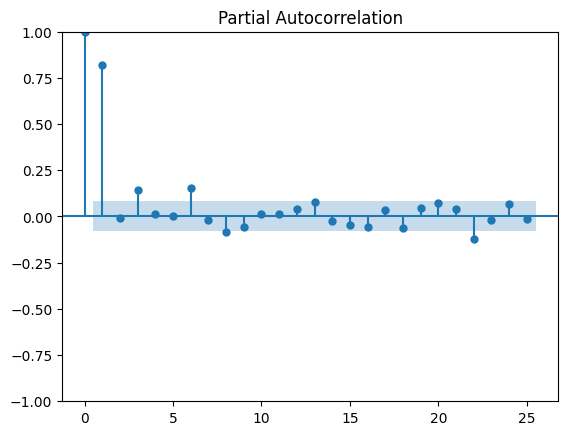

In [21]:
# Visualize autocorrelation using plot_acf
plot_acf(GWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(GWAP_train, lags=25, alpha=0.05)

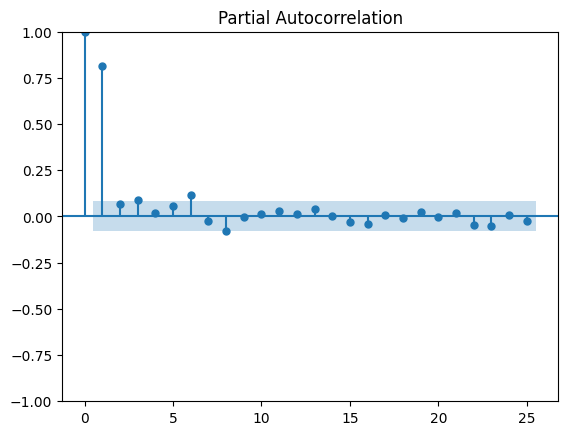

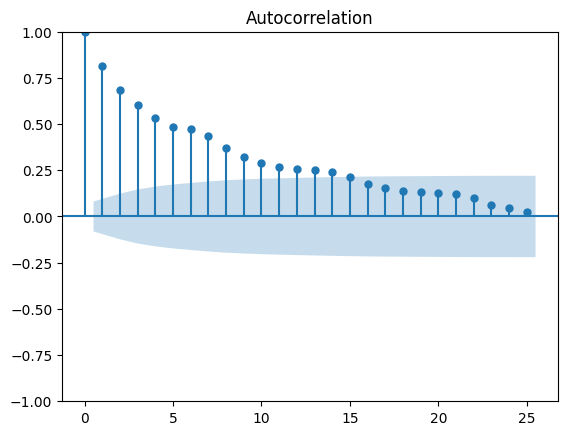

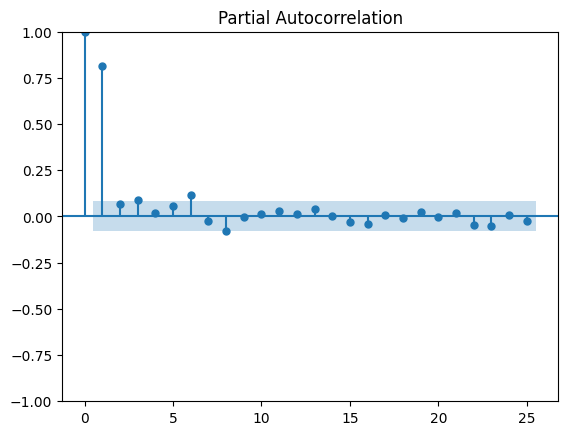

In [19]:
#VISAYAS LWAP
# Visualize autocorrelation using plot_acf
plot_acf(LWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(LWAP_train, lags=25, alpha=0.05)

Forecast using statsmodels

In [22]:
def seasonal_auto_arima(df, max_p, max_d, max_q, exog_data=None):
    lowest_aic = float("inf")
    best_model = None
    
    # Sequence of seasonal periods to try
    seq = [1,2,3,4,5,6,7,14,30]
    for i in seq:
        try:
            model = auto_arima(df, 
                               start_p=0, start_d=0, start_q=0,
                               max_p=max_p, max_d=max_d, max_q=max_q, 
                               seasonal=True, m=i, 
                               start_P=0, start_D=0, start_Q=0,
                               error_action='warn', trace=False,
                               suppress_warnings=True, stepwise=False,
                               exog=exog_data, 
                               maxiter=300, method='powell')
            
            if model.aic() < lowest_aic:
                lowest_aic = model.aic()
                best_model = model

        except Exception as e:
            print(f"Model fitting failed for seasonality {i}: {e}")

    try:
        model = auto_arima(df, 
                           start_p=0, start_d=0, start_q=0,
                           max_p=max_p, max_d=max_d, max_q=max_q, 
                           seasonal=False,
                           error_action='warn', trace=False,
                           suppress_warnings=True, stepwise=False,
                           exog=exog_data, 
                           maxiter=300, method='powell')
        
        if model.aic() < lowest_aic:
            lowest_aic = model.aic()
            best_model = model

    except Exception as e:
        print(f"Non-seasonal model fitting failed: {e}")

    if best_model is not None:
        if best_model.seasonal_order == (0, 0, 0, 0):
            print(f"The model with the lowest AIC is non-seasonal with an AIC of {lowest_aic}")
        else:
            print(f"The model with the lowest AIC has a seasonal period of {best_model.seasonal_order[3]} and an AIC of {lowest_aic}")
    else:
        print("No suitable model found.")
        
    return best_model

# Example usage
# data = pd.read_csv('your_time_series_data.csv', parse_dates=True, index_col='Date')
# exog_data = pd.read_csv('your_exogenous_data.csv', parse_dates=True, index_col='Date')
# best_model = seasonal_auto_arima('your_target_column', data, max_p=5, max_d=2, max_q=5, exog_data=exog_data)


In [23]:
GWAP_sarimax = seasonal_auto_arima(GWAP_train, max_p=1, max_d=2, max_q=10, exog_data=diff_exog_train )

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecatio

The model with the lowest AIC has a seasonal period of 14 and an AIC of -1318.9123847629455


In [24]:
GWAP_sarimax

ARIMA(maxiter=300, method='powell', order=(1, 1, 1), scoring_args={},
      seasonal_order=(2, 0, 0, 14), suppress_warnings=True)

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -1.156860
         Iterations: 10
         Function evaluations: 1531


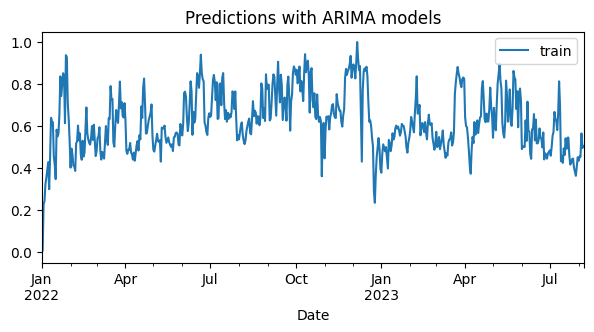

In [30]:
#Using statsmodels

gwap_model_weekly = SARIMAX(endog = GWAP_train, exog = diff_exog_train, order=(1, 1, 1), seasonal_order=(2,0,0,14))
fitted_gwap_model_weekly=gwap_model_weekly.fit(method='powell', maxiter=300)

gwap_train_predict = fitted_gwap_model_weekly.predict(start='2022-01-01', end='2023-08-07', exog=diff_exog_train)
fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [31]:
fitted_gwap_model_weekly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                GWAP   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 14)   Log Likelihood                 675.606
Date:                             Sat, 28 Dec 2024   AIC                          -1319.212
Time:                                     17:27:43   BIC                          -1249.321
Sample:                                 01-01-2022   HQIC                         -1291.970
                                      - 08-07-2023                                         
Covariance Type:                               opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
FLOW_VIS                0.0016      0.025      0.062      0.950      -0.048       0.051
TMIN_Dumaguete          0.0306      0.018      1.654      0.098      -0.006       0.067
TMAX_Catbalogan         0.0262      0.019      1.362      0.173      -0.012       0.064
RESERVE_GWAP_Fr         0.0231      0.019      1.189      0.234      -0.015       0.061
RESERVE_GWAP_Ru         0.0207      0.014      1.479      0.139      -0.007       0.048
RESERVE_GWAP_Rd         0.0090      0.008      1.137      0.256      -0.007       0.025
RESERVE_GWAP_Dr         0.0123      0.014      0.870      0.384      -0.015       0.040
RAINFALL_Catbalogan    -0.0187      0.014     -1.356      0.175      -0.046       0.008
RAINFALL_Roxas City     0.0175      0.013      1.377      0.168      -0.007       0.042
RAINFALL_Catarman      -0.0064      0.016     -0.389      0.698      -0.038       0.026
RAINFALL_Maasin        -0.0066      0.012     -0.542      0.588      -0.030       0.017
ar.L1                   0.8222      0.027     30.266      0.000       0.769       0.875
ma.L1                  -0.9837      0.011    -89.836      0.000      -1.005      -0.962
ar.S.L14                0.0961      0.040      2.386      0.017       0.017       0.175
ar.S.L28                0.1637      0.050      3.281      0.001       0.066       0.262
sigma2                  0.0057      0.000     19.695      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):                37.11
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.21
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

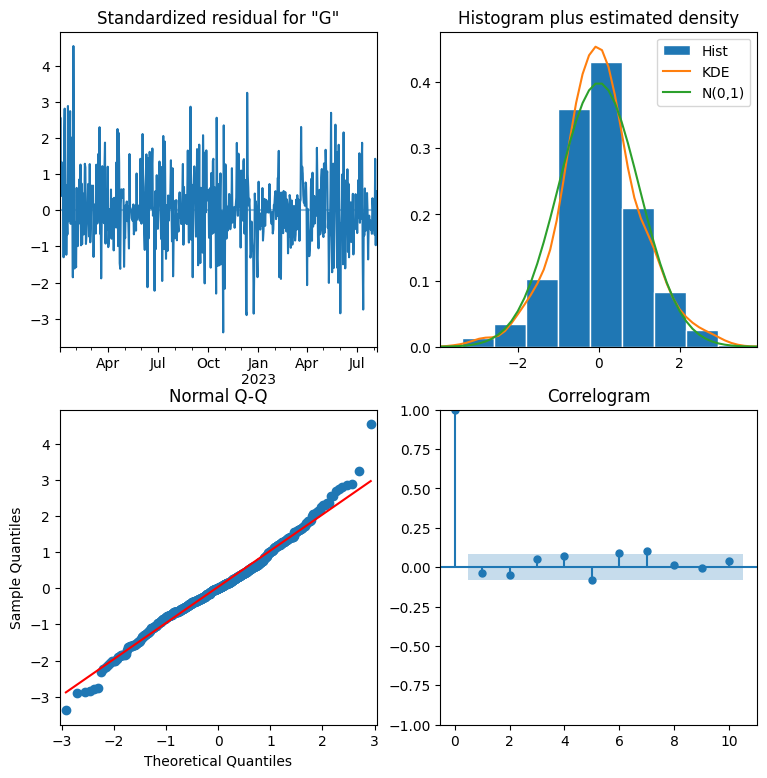

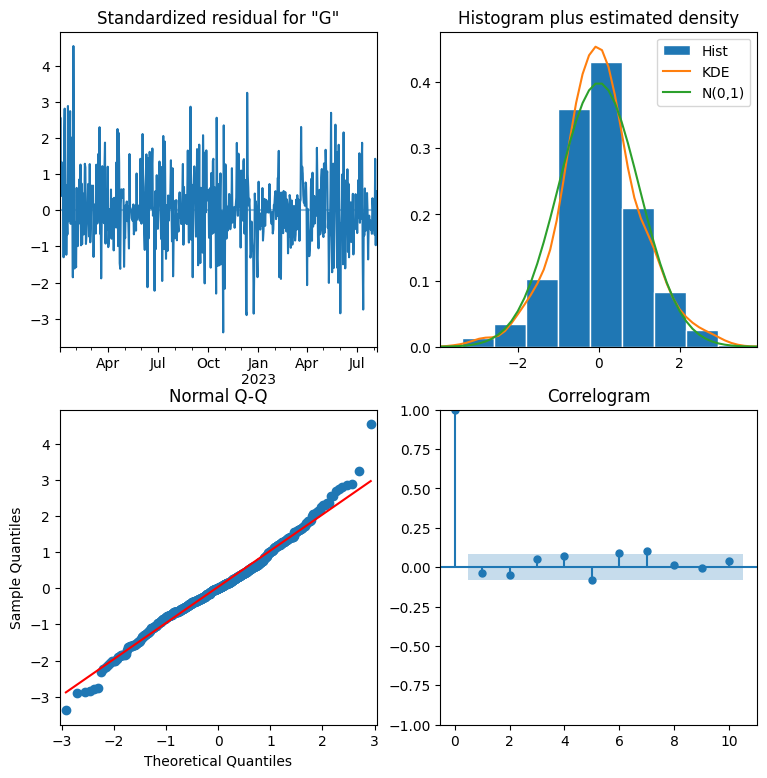

In [32]:
fitted_gwap_model_weekly.plot_diagnostics(figsize=(9,9))


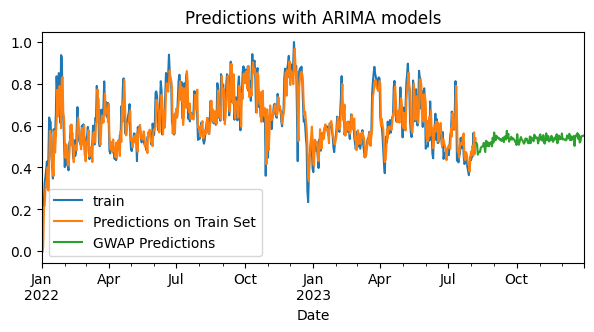

In [33]:
gwap_test_predict = fitted_gwap_model_weekly.predict(start='2023-8-8', end='2023-12-31', exog=diff_exog_test, dynamic=True)

fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
gwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
gwap_test_predict.plot(ax=ax, label='GWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [34]:
LWAP_sarimax = seasonal_auto_arima(LWAP_train, max_p=1, max_d=2, max_q=14, exog_data=diff_exog_train )

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecatio

The model with the lowest AIC has a seasonal period of 14 and an AIC of -1222.0867039329976


In [35]:
LWAP_sarimax

ARIMA(maxiter=300, method='powell', order=(1, 1, 1), scoring_args={},
      seasonal_order=(2, 0, 0, 14), suppress_warnings=True)

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -1.074002
         Iterations: 9
         Function evaluations: 1373


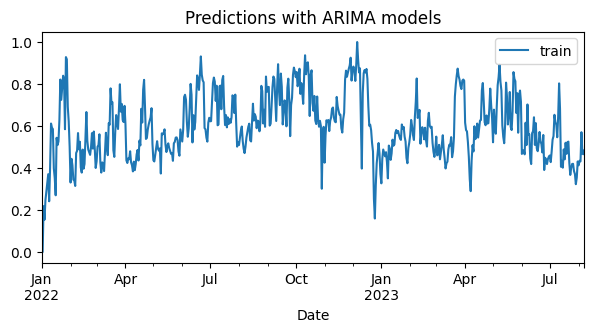

In [36]:
lwap_model_weekly = SARIMAX(endog = LWAP_train, exog = diff_exog_train, order=(1, 1, 1), seasonal_order=(2,0,0,14))
fitted_lwap_model_weekly=lwap_model_weekly.fit(method='powell', maxiter=300)
#Check fit on train set
lwap_train_predict = fitted_lwap_model_weekly.predict(start='2022-01-01', end='2023-08-07', exog=diff_exog_train)
fig, ax = plt.subplots(figsize=(7, 3))
LWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [37]:
fitted_lwap_model_weekly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                LWAP   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 14)   Log Likelihood                 627.217
Date:                             Sat, 28 Dec 2024   AIC                          -1222.434
Time:                                     18:27:04   BIC                          -1152.543
Sample:                                 01-01-2022   HQIC                         -1195.192
                                      - 08-07-2023                                         
Covariance Type:                               opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
FLOW_VIS                0.0091      0.028      0.322      0.747      -0.046       0.064
TMIN_Dumaguete          0.0309      0.020      1.562      0.118      -0.008       0.070
TMAX_Catbalogan         0.0309      0.021      1.477      0.140      -0.010       0.072
RESERVE_GWAP_Fr         0.0254      0.021      1.230      0.219      -0.015       0.066
RESERVE_GWAP_Ru         0.0203      0.015      1.335      0.182      -0.009       0.050
RESERVE_GWAP_Rd         0.0091      0.008      1.097      0.273      -0.007       0.025
RESERVE_GWAP_Dr         0.0130      0.015      0.849      0.396      -0.017       0.043
RAINFALL_Catbalogan    -0.0219      0.015     -1.461      0.144      -0.051       0.007
RAINFALL_Roxas City     0.0177      0.014      1.289      0.197      -0.009       0.045
RAINFALL_Catarman      -0.0056      0.018     -0.315      0.753      -0.040       0.029
RAINFALL_Maasin        -0.0089      0.013     -0.679      0.497      -0.035       0.017
ar.L1                   0.8153      0.027     30.128      0.000       0.762       0.868
ma.L1                  -0.9838      0.011    -91.239      0.000      -1.005      -0.963
ar.S.L14                0.1070      0.040      2.674      0.007       0.029       0.185
ar.S.L28                0.1791      0.050      3.618      0.000       0.082       0.276
sigma2                  0.0068      0.000     19.031      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   1.29   Jarque-Bera (JB):                25.65
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.17
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

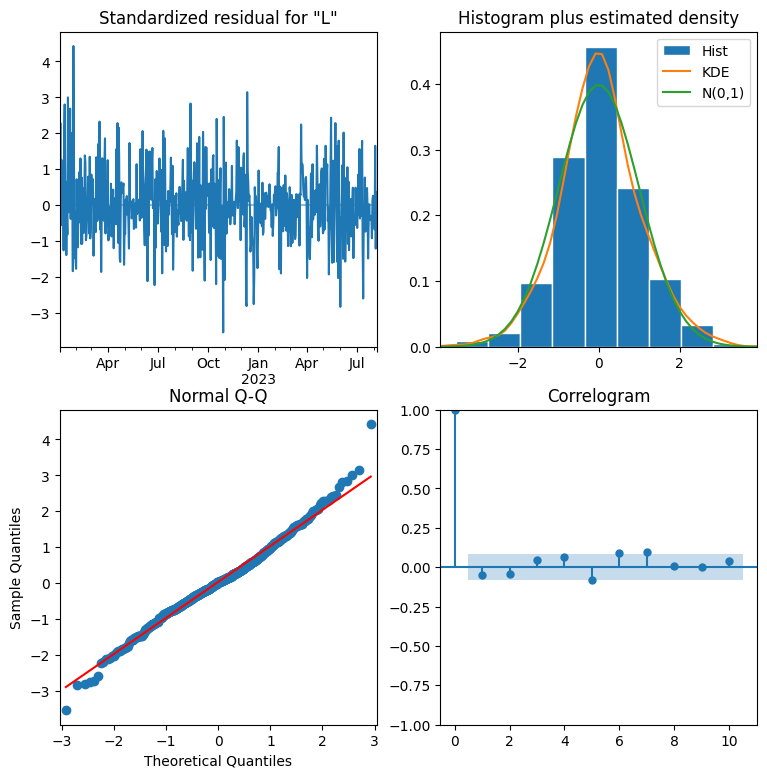

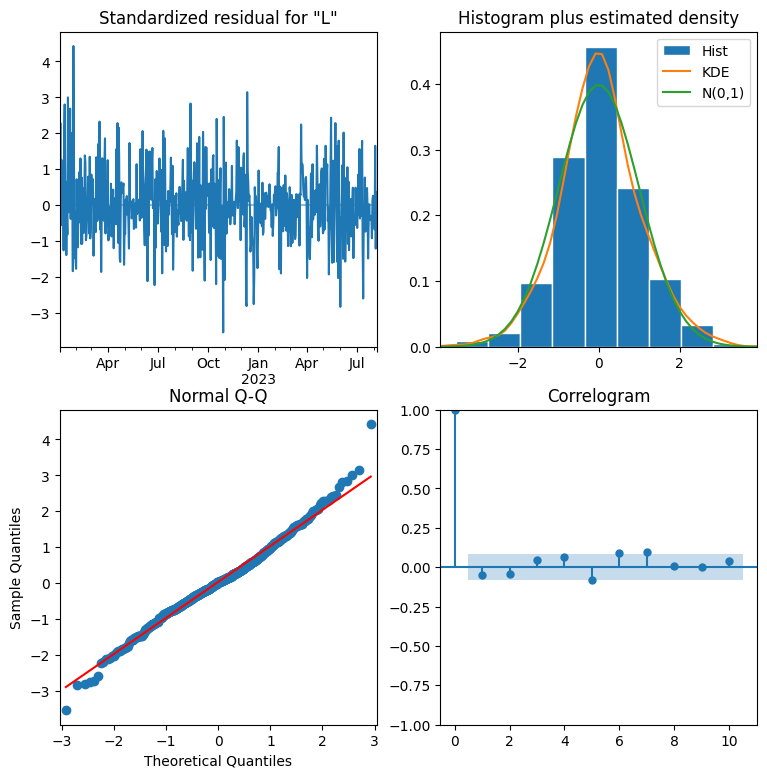

In [38]:
fitted_lwap_model_weekly.plot_diagnostics(figsize=(9,9))

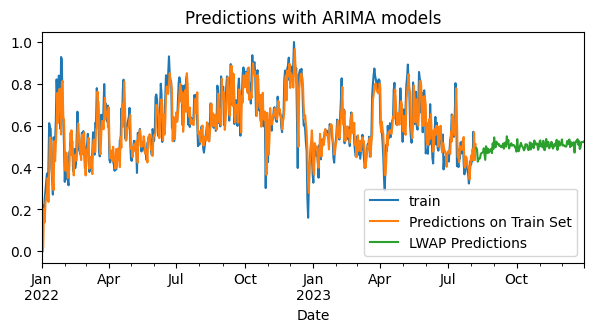

In [39]:
#Predict using LWAP mdodel and plot predictions
lwap_test_predict = fitted_lwap_model_weekly.predict(start='2023-8-8', end='2023-12-31', exog=diff_exog_test, dynamic=True)

fig, ax = plt.subplots(figsize=(7, 3))
LWAP_train.plot(ax=ax, label='train')
lwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
lwap_test_predict.plot(ax=ax, label='LWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

Applying inverse transformations - non-rolling

In [40]:
all_predictions = pd.concat([gwap_test_predict, lwap_test_predict], axis=1)
all_predictions_inverse=boxcoxy_fit_loaded.inverse_transform(all_predictions)
all_predictions_inverse

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but PowerTransformer was fitted with feature names



array([[5568.95483312, 6221.11616323],
       [5404.10953701, 5996.66520691],
       [4397.7636535 , 4900.40341772],
       [4573.06023754, 5134.66327919],
       [4648.81073951, 5155.84144671],
       [4634.42288537, 5195.40710271],
       [5038.34058102, 5582.4743404 ],
       [5109.74832026, 5680.02589114],
       [5195.25301218, 5727.94990979],
       [5199.2985817 , 5765.26664697],
       [5563.51360987, 6170.691326  ],
       [5087.77433351, 5551.71846274],
       [4632.95486528, 5050.01311907],
       [5802.05480237, 6397.84217141],
       [5720.23950951, 6202.35866314],
       [5218.70939251, 5675.37603941],
       [5606.45662223, 6120.08046158],
       [5191.52179198, 5722.41443621],
       [5477.78150884, 5894.76216497],
       [5594.20450464, 6021.36188121],
       [5647.22090009, 6117.17221692],
       [5190.87277722, 5668.90791124],
       [6165.67469723, 6731.42927721],
       [5594.27255633, 6111.98491603],
       [6857.92002547, 7495.06713798],
       [6046.41908912, 65

In [41]:
all_predictions_inverse_df = pd.DataFrame(all_predictions_inverse)
all_predictions_inverse_df.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)

GWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 0], columns=['GWAP'])
GWAP_predictions_inverse = pd.concat([test_date,GWAP_predictions_inverse], axis=1)
GWAP_predictions_inverse.set_index('Date', inplace=True)
GWAP_predictions_inverse.index = pd.to_datetime(GWAP_predictions_inverse.index)
GWAP_predictions_inverse.index.freq='D'
GWAP_predictions_inverse = GWAP_predictions_inverse.squeeze()

LWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 1], columns=['LWAP'])
LWAP_predictions_inverse = pd.concat([test_date,LWAP_predictions_inverse], axis=1)
LWAP_predictions_inverse.set_index('Date', inplace=True)
LWAP_predictions_inverse.index = pd.to_datetime(LWAP_predictions_inverse.index)
LWAP_predictions_inverse.index.freq='D'
LWAP_predictions_inverse = LWAP_predictions_inverse.squeeze()

In [42]:
# Calculate MAE for the Visayas GWAP test set
mae_test = mean_absolute_error(GWAP_test_inversed, GWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Visayas GWAP test set
mse_test = mean_squared_error(GWAP_test_inversed, GWAP_predictions_inverse)
rmse_test = np.sqrt(mse_test)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")
GWAP.plot(ax=ax, label='Original Data')
GWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Visayas GWAP Predictions')
ax.legend()
plt.show()

Mean Absolute Error (MAE) on Test Set: 2038.504657857837
Root Mean Squared Error (RMSE) on Test Set: 3110.832797219246


Mean Absolute Error (MAE) on Test Set: 2223.530285158075
Root Mean Squared Error (RMSE) on Test Set: 3304.853682942884


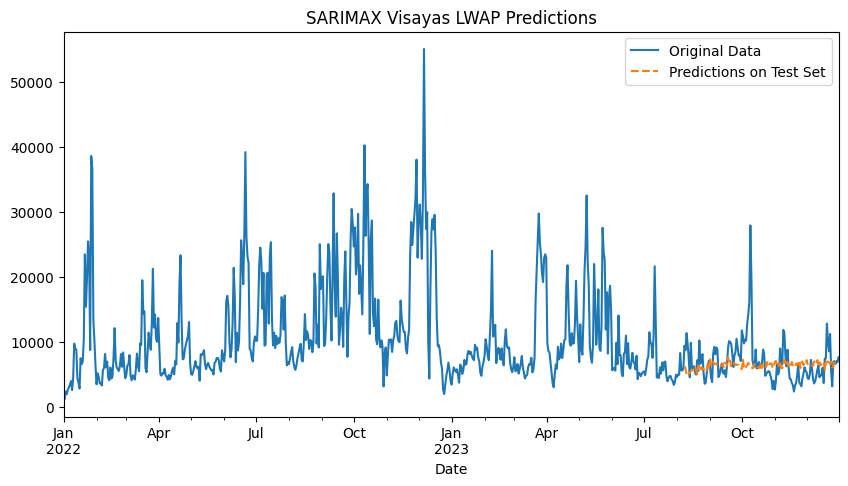

In [43]:
# Calculate MAE for the Visayas LWAP test set
mae_test = mean_absolute_error(LWAP_test_inversed, LWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Visayas LWAP test set
mse_test = mean_squared_error(LWAP_test_inversed, LWAP_predictions_inverse)
rmse_test = np.sqrt(mse_test)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original Data')
LWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Visayas LWAP Predictions')
ax.legend()
plt.show()

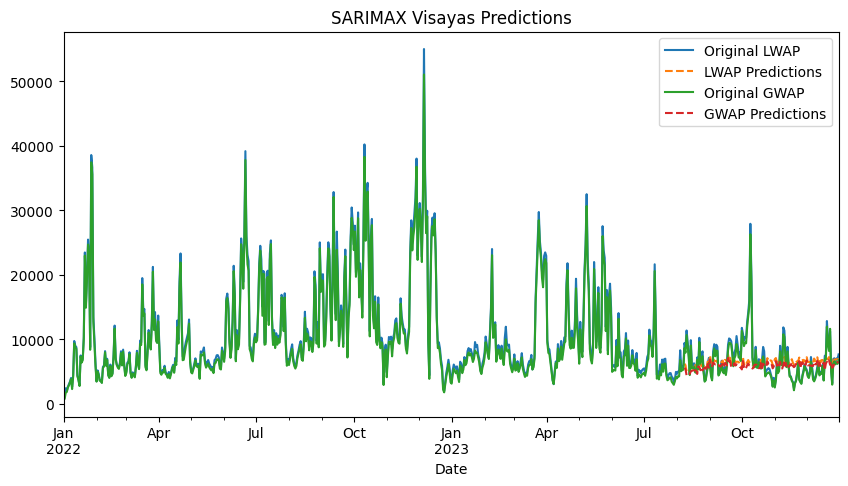

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original LWAP')
LWAP_predictions_inverse.plot(ax=ax, label='LWAP Predictions', linestyle='--')
GWAP.plot(ax=ax, label='Original GWAP')
GWAP_predictions_inverse.plot(ax=ax, label='GWAP Predictions', linestyle='--')
ax.set_title('SARIMAX Visayas Predictions')
ax.legend()
plt.show()

In [49]:
GWAP_predictions_inverse.to_csv('vis-gwap-predictions.csv', index=False)
LWAP_predictions_inverse.to_csv('vis-lwap-predictions.csv', index=False)